<h3>Predictive Maintenance</h3>
<p>Based on kaggle dataset<br>
<a href='https://www.kaggle.com/ludobenistant/predictive-maintenance-1/data'>https://www.kaggle.com/ludobenistant/predictive-maintenance-1/data</a>
</p>
<p>Step by step approach with pandas data frames, then have a HL view of Dask possibilities, then see NN of the data.</p>

In [1]:
# Import Libraries needed
import pandas as pd                 #dataframe manipulation
import numpy as np                  #numerical processing of vectors
import matplotlib.pyplot as plt     #plotting
%matplotlib inline                

#import tensorflow as tf
import sklearn
from sklearn import tree
import graphviz
import dask


print("Pandas:\t\t", pd.__version__)
print("Numpy:\t\t", np.__version__)
#print("Tensorflow:\t", tf.__version__)
print("Dask:\t\t", dask.__version__)
print("Scikit-learn:\t", sklearn.__version__)

Pandas:		 0.22.0
Numpy:		 1.14.0
Dask:		 0.16.0
Scikit-learn:	 0.19.1


In [2]:
df_init = df = pd.read_csv('./maintenance_data.csv')

In [3]:
df.columns

Index(['lifetime', 'broken', 'pressureInd', 'moistureInd', 'temperatureInd',
       'team', 'provider'],
      dtype='object')

In [4]:
df.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [5]:
df.describe()

,lifetime,broken,pressureInd,moistureInd,temperatureInd
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,55.195000,0.397000,98.599338,99.376723,100.628541
std,26.472737,0.489521,19.964052,9.988726,19.633060
min,1.000000,0.000000,33.481917,58.547301,42.279598
25%,34.000000,0.000000,85.558076,92.771764,87.676913
50%,60.000000,0.000000,97.216997,99.433959,100.592277
75%,80.000000,1.000000,112.253190,106.120762,113.662885
max,93.000000,1.000000,173.282541,128.595038,172.544140


In [6]:
df.sort_values(by='lifetime', ascending=True).head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
52,1,0,72.423129,120.484155,116.400433,TeamB,Provider2
205,1,0,92.100802,89.994611,97.292290,TeamB,Provider1
464,1,0,141.042595,113.358822,91.310554,TeamC,Provider2
71,1,0,107.785993,117.390336,113.377308,TeamB,Provider4
209,1,0,104.658530,107.537666,126.374317,TeamB,Provider1


In [7]:
df.sort_values(by='lifetime', ascending=True).tail()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
283,93,1,79.639584,115.057383,87.223725,TeamB,Provider2
746,93,1,81.289168,105.856819,80.757421,TeamB,Provider2
106,93,1,109.671138,104.600332,102.881957,TeamB,Provider2
154,93,1,129.585306,93.692108,84.915725,TeamA,Provider2
649,93,1,92.976675,98.641371,101.332116,TeamA,Provider2


<Container object of 1000 artists>

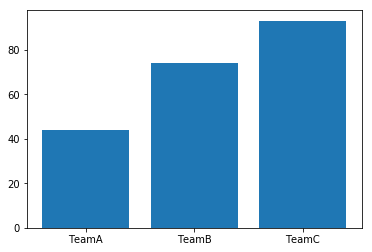

In [8]:
plt.bar(df.sort_values('team').team, df.sort_values('lifetime').lifetime)

In [9]:
df.groupby([df.team, df.broken]).count()

lifetime  pressureInd  moistureInd  temperatureInd  provider
team  broken                                                              
TeamA 0            213          213          213             213       213
      1            123          123          123             123       123
TeamB 0            206          206          206             206       206
      1            150          150          150             150       150
TeamC 0            184          184          184             184       184
      1            124          124          124             124       124

In [10]:
df.groupby(['team','broken']).agg({'broken': 'count'}).apply(lambda x:100 * x / float(x.sum()))

broken
team  broken        
TeamA 0         21.3
      1         12.3
TeamB 0         20.6
      1         15.0
TeamC 0         18.4
      1         12.4

In [11]:
show_perc = df.groupby(['team','broken']).agg({'broken': 'count'})
show_perc.apply(lambda x:100 * x / float(x.sum()))

broken
team  broken        
TeamA 0         21.3
      1         12.3
TeamB 0         20.6
      1         15.0
TeamC 0         18.4
      1         12.4

In [12]:
column = 'provider'
show_perc = df.loc[df['broken'] == 1].groupby([column]).agg({'broken': 'count'})
show_perc.apply(lambda x:round(100 * x / float(x.sum()),2)).rename(columns={"broken": "%"})

,%
provider,
Provider1,29.22
Provider2,22.92
Provider3,28.72
Provider4,19.14


<h3>Decision Tree Classification of existing Data with Scikit-learn</h3>
<p>Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
<br>
http://scikit-learn.org/stable/modules/tree.html</p>

In [13]:
tree_data = df_init.drop(columns=['broken'])
tree_target = df_init.broken

#workaround replacement strings to integers - DO NOT DO IT LIKE THIS ;-)
try:
    tree_data.replace('TeamA',1, inplace=True)
    tree_data.replace('TeamB',2, inplace=True)
    tree_data.replace('TeamC',3, inplace=True)
    tree_data.replace('Provider1',1, inplace=True)
    tree_data.replace('Provider2',2, inplace=True)
    tree_data.replace('Provider3',3, inplace=True)
    tree_data.replace('Provider4',4, inplace=True)
except:
    pass  

#convert dataframes to arrays
tree_data = tree_data.values
tree_target = tree_target.values
#column names - labels
tree_feature_names = ['lifetime', 'pressureInd', 'moistureInd', 'temperatureInd', 'team', 'provider']
#target names - class
tree_target_names = ['BROKEN!','Operational']

#Tree Classifiers
tree_clf = tree.DecisionTreeClassifier()

#tree_clf.set_params(max_depth=2)

tree_clf = tree_clf.fit(tree_data, tree_target)

tree_clf.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

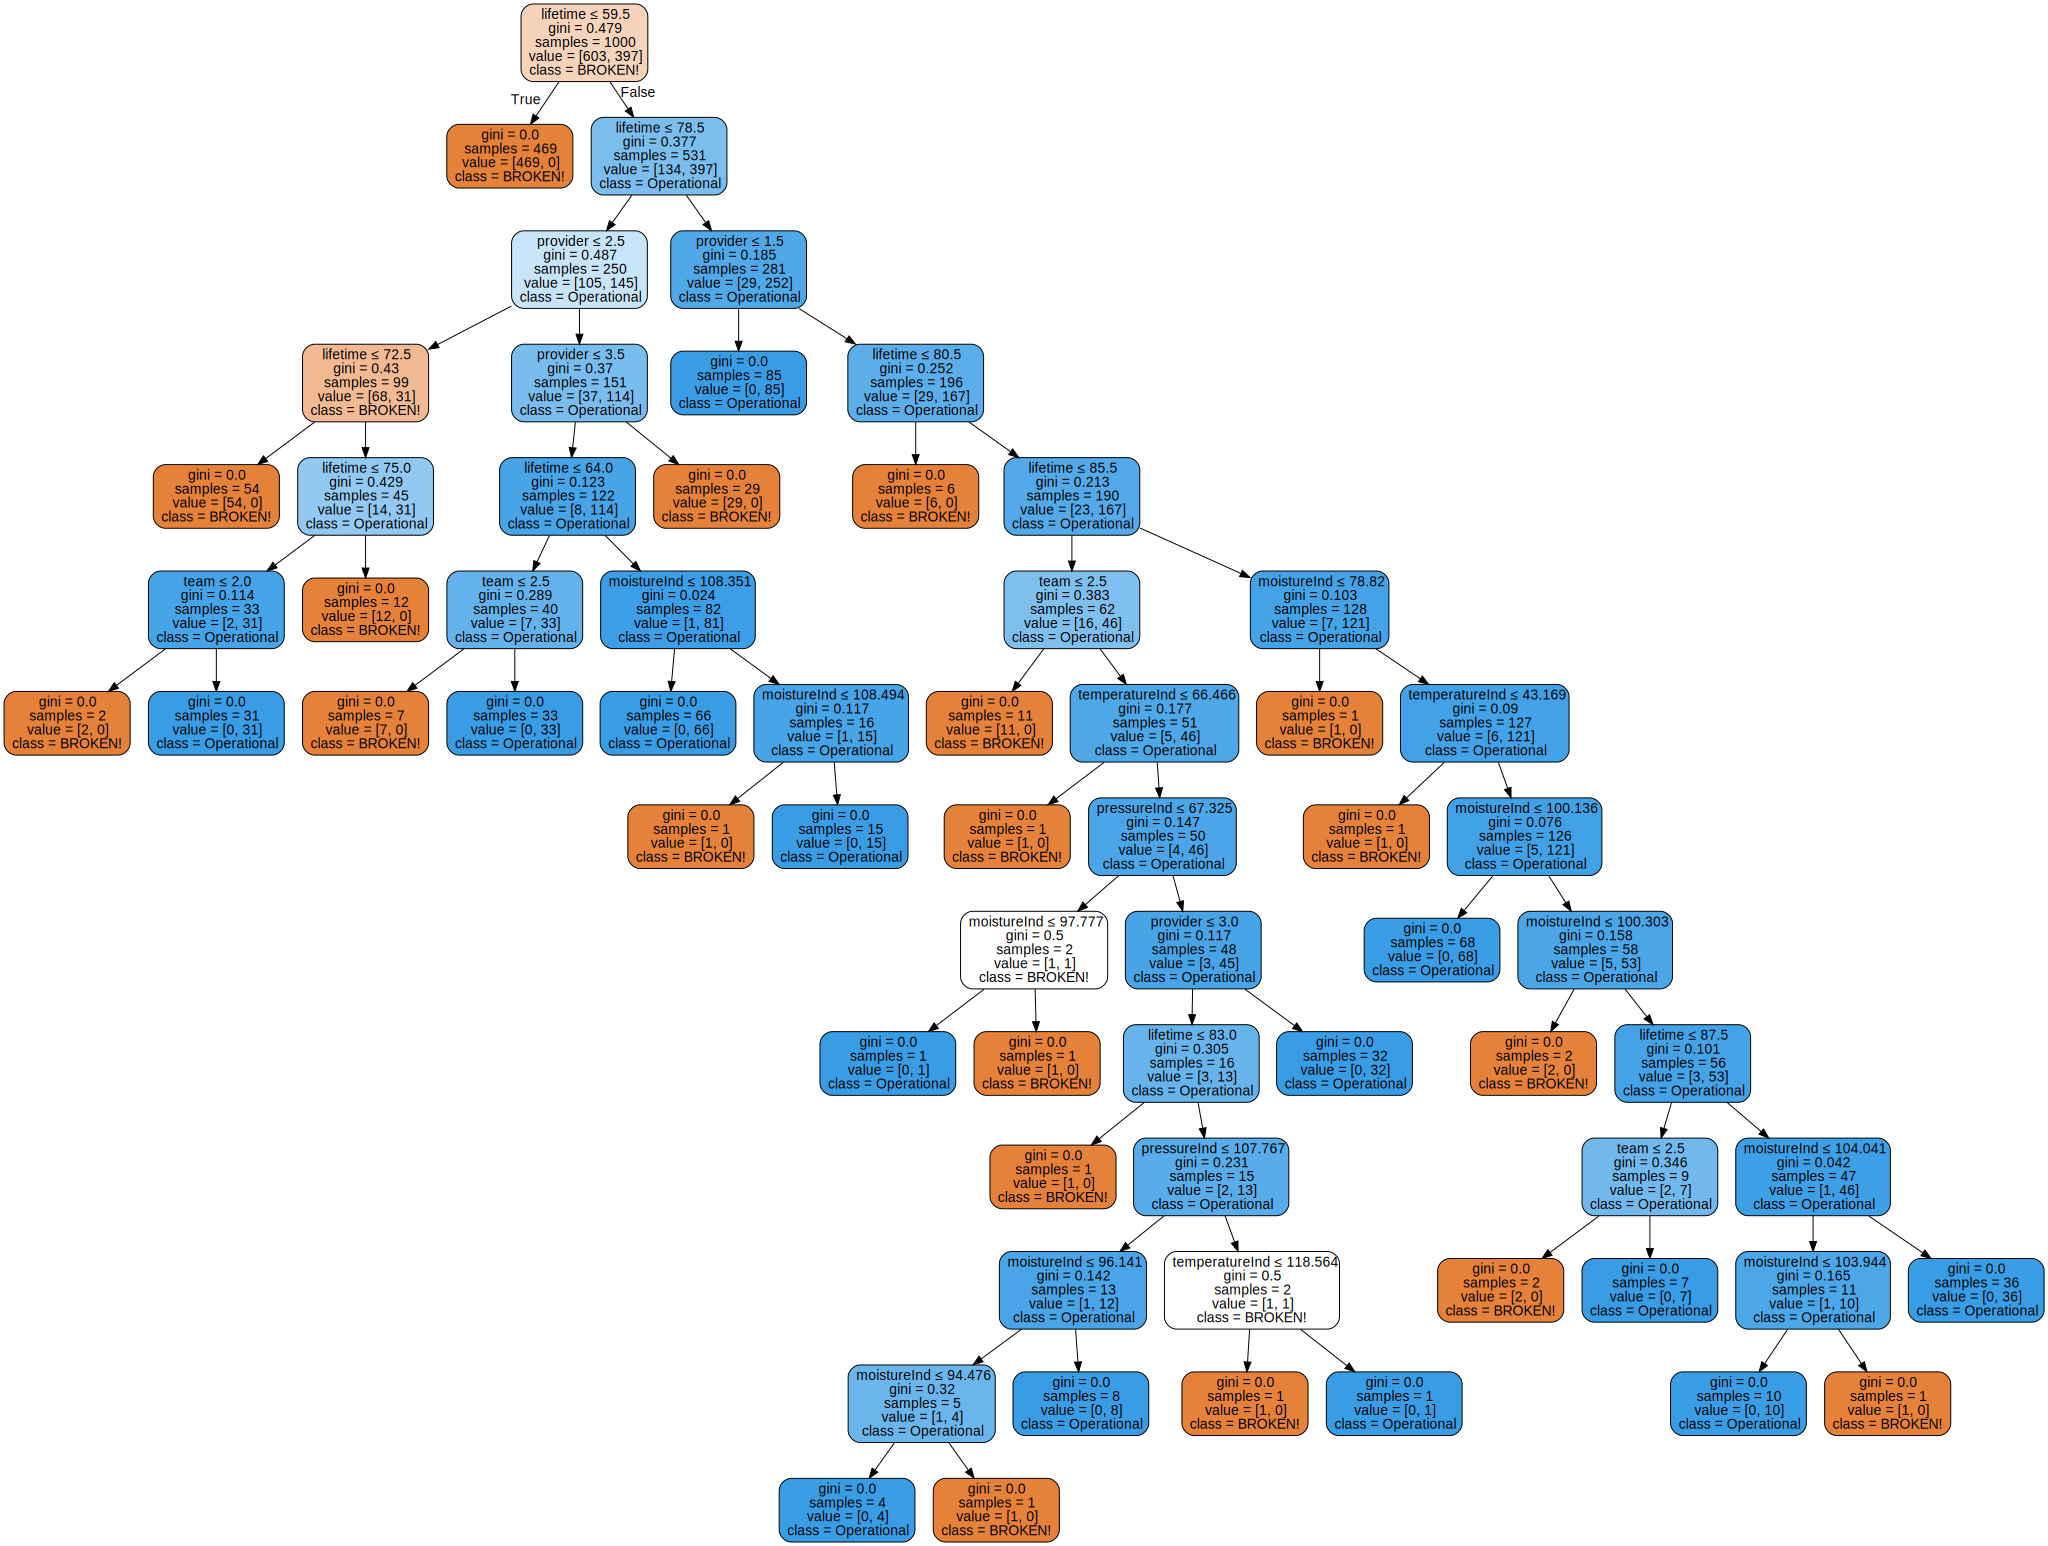

In [14]:
#output graph tree
tree_dot_data = tree.export_graphviz(tree_clf, 
                                out_file=None, 
                                feature_names=tree_feature_names,
                                class_names=tree_target_names,
                                filled=True, 
                                rounded=True,
                                special_characters=True) 
graph = graphviz.Source(tree_dot_data) 
graph.render("Maintenance_classification_tree")
#show tree
graph 

<h3 align='center'>To better have a look at the tree</h3><p><a href='./Maintenance_classification_tree.pdf' target='_blank'><img src='./images/tree.png' border=0></a></p>

In [15]:
df_init.drop(columns=['broken']).columns

Index(['lifetime', 'pressureInd', 'moistureInd', 'temperatureInd', 'team',
       'provider'],
      dtype='object')

In [16]:
#PREDICTION WITHOUT REGRESSION - 1-->BROKEN 0-->Operational
print('instance 1 prediction: ', tree_clf.predict([[70., 100., 100., 100., 1., 3.]]))
print('instance 2 prediction: ', tree_clf.predict([[70., 100., 100., 100., 1., 1.]]))

instance 1 prediction:  [1]
instance 2 prediction:  [0]
